# Algorithm de détection des faux billets

> Par Valentin MONTEIRO

## Import Package

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Package perso

!pip install Valeeew
from valeeew import cleaning as cl

# Package scikit learn

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import decomposition

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score

import scipy.stats as st
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import DATA

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DATA/P10/billets.csv", delimiter=";")
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


## DATA Cleaning

Null DATA and nothing duplicate 

Total missing value 
 
 is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64 

Percentage of missing value 
 
 is_genuine      0.00
diagonal        0.00
height_left     0.00
height_right    0.00
margin_up       0.00
length          0.00
margin_low      2.47
dtype: float64 

Empty DataFrame
Columns: [is_genuine, diagonal, height_left, height_right, margin_low, margin_up, length]
Index: [] 



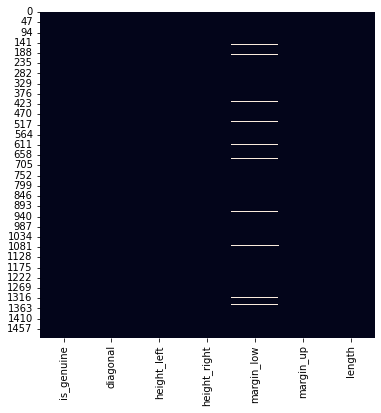

In [ ]:
# Utilisation du Package perso
cl.watch(df)

37 valeurs sont manquante dans la colonne margin_low

### Imputation par régression linéaire

In [ ]:
# Je sépare les individus manquant des complets
df_nan = df[df.margin_low.isna()]
df_full = df.dropna(axis=0)

In [ ]:
# Je prépare mon entrainement de prédiction X ➡️ y
X = df_full.drop("margin_low", axis=1)
y = df_full.margin_low
print("X",X.shape)

X (1463, 6)


In [ ]:
# Je met y aux même dismension que X
y = np.array(y)
y = y.reshape(1463,1)
print("y", y.shape)

y (1463, 1)


In [ ]:
# Je standardise mes DATA
stdscl = StandardScaler()
x = stdscl.fit_transform(X)

In [ ]:
# J'entraîne mon model de régréssion linéaire
reg = LinearRegression()
reg.fit(x,y)
reg.score(x,y)
# Ajout colonne prediction
df_full["y_pred"] = reg.predict(X)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Le modèle de régréssion linéaire est **fiable à environ 62%**

In [ ]:
#Régression Linéaire Multiple de margin_low en fonction des autres variables 
resultats = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df).fit()
print(resultats.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Tue, 15 Nov 2022   Prob (F-statistic):          2.60e-202
Time:                        22:57:46   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

> R^2 = 0,477

> Toutes mes **Pvalue** sont inférieures à 0,05, donc les variables sont toutes significatives au calcul

> **Le coeficient de détermination R^2 à déjà été calculer avec reg.score()** ➡️ **0,62**

> **Durbin-Watson = 1.893** ➡️ entre 1,5 et 2,5 on peut **rejeter l'autocorrélation**

In [ ]:
# Colonne residu ➡️ écart entre margin low réel et prédite
df_full["residual"] = df_full.margin_low - df_full.y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### **Vérification de l'hypothèse de multicolinéarité**

> Hypothèse : **Multicolinéarité** si vif pour une **variable >= 10**

In [ ]:
from numpy.ma.core import arange
v = resultats.model.exog

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(v,i).round(2) for i in np.arange(1,v.shape[1])]
print(vif)

[1.01, 1.14, 1.23, 1.4, 1.58]


> Tout les coefficients sont proche de 1, et donc inferieur à 10
<br>➡️ **Pas de multicolinéarité** 

### **Homoscédasticité des résidus**


Les résidus doivent avoir une variance relative constante pour être Homoscédasticite


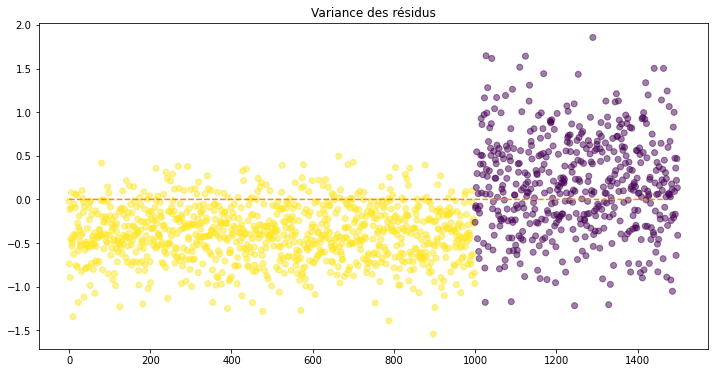

In [ ]:
print('Les résidus doivent avoir une variance relative constante pour être Homoscédasticite')
plt.subplots(figsize=(12, 6))
plt.scatter(x=df_full.index, y=df_full.residual, alpha=0.5, c=df_full.is_genuine)
plt.plot(np.repeat(0, len(df_full.index)), color='darkorange', linestyle='--')
plt.title('Variance des résidus')
plt.show()

> On voit clairement que la variance n'est pas constante<br>
➡️ entre 0,5 et -1,5 pour les milles premières valeurs environ<br>
➡️ entre 2 et -1,5 pour les 500 dernières

In [ ]:
#Test de l'Homoscédasticité
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
 
#Résultats du test
test_result = sms.het_breuschpagan(resultats.resid, resultats.model.exog)
lzip(names, test_result)

[('Lagrange multiplier statistic', 80.16261280172587),
 ('p-value', 7.759535216287205e-16),
 ('f-value', 16.892358846147992),
 ('f p-value', 2.92274965665814e-16)]

> **Pvalue < 0,05** ➡️ Il y a Hétéroscédasticité

### **Normalité des résidu** Shapiro
> Distribution normal si P value > 0,05

<function matplotlib.pyplot.show(*args, **kw)>

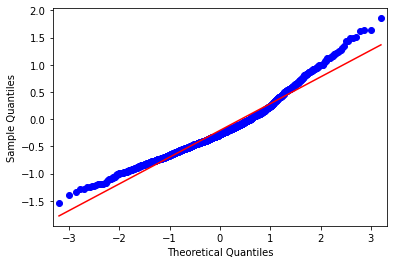

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df_full.residual, line="s")
plt.show

In [ ]:
print("stats = ",st.shapiro(df_full.residual)[0],"\n",
"P value = ",st.shapiro(df_full.residual)[1])

stats =  0.9636063575744629 
 P value =  1.0708191139574324e-18


**P value < 0,05** ➡️ la distribution n'est pas normal

In [ ]:
df_full.drop("y_pred",axis="columns",inplace=True)
df_full.drop("residual",axis="columns",inplace=True)
df_full

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [ ]:
# Préparation de X_nan
X_nan = df_nan.dropna(axis=1)

# Prédiction de X_nan
y_pred = reg.predict(X_nan)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
# Imputation
df_nan.margin_low = y_pred

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_nan

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.498433,3.25,112.79
99,True,171.93,104.07,104.18,4.510761,3.14,113.08
151,True,172.07,103.80,104.38,4.516069,3.02,112.93
197,True,171.45,103.66,103.80,4.481617,3.62,113.27
241,True,171.83,104.14,104.06,4.519062,3.02,112.36
251,True,171.80,103.26,102.82,4.501508,2.95,113.22
284,True,171.92,103.83,103.76,4.499982,3.23,113.29
334,True,171.85,103.70,103.96,4.511983,3.00,113.36
410,True,172.56,103.72,103.51,4.500909,3.12,112.95
413,True,172.30,103.66,103.50,4.499377,3.16,112.95


In [ ]:
# Union des DATA full et nan puis tri dans ordre croissant de l'indexation
df =pd.concat([df_full, df_nan])
df.sort_index(axis=0, ascending=True, inplace=True)
df.to_csv("billet_clean.csv")
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


## ACP

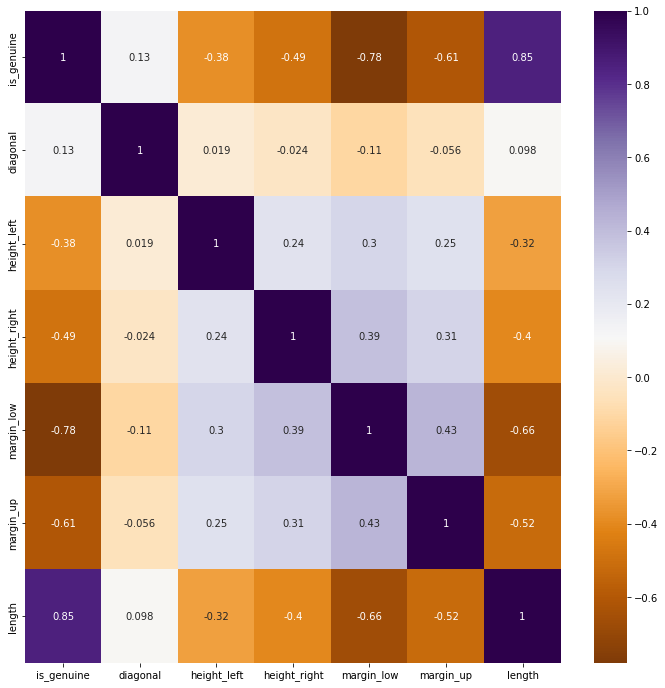

In [ ]:
# Matrice des corrélations
plt.figure(figsize=(12,12))
matrix = df[df.columns].corr()
sns.heatmap(data=matrix, annot=True, cmap="PuOr")

In [ ]:
# Preprocessing
X = df.values
name = df.index
variable = df.columns
X_scaled = StandardScaler().fit_transform(X)

J'ai choisi 2 composante car on explore pas les données, ici nous savons qu'on veut un résultat vrai ou faux


In [ ]:
pca = decomposition.PCA(2)
pca.fit(X_scaled)

PCA(n_components=2)

In [ ]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[0, i],  
                pca.components_[1, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[0, i] + 0.05,
                pca.components_[1, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

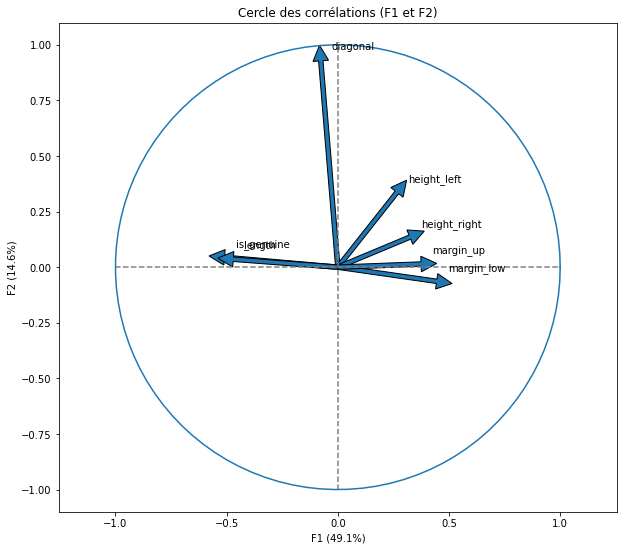

In [ ]:
correlation_graph(pca,(0,1),variable)

In [ ]:
X_proj = pca.transform(X_scaled)

In [ ]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    plt.scatter(   X_[:, x], 
                        X_[:, y], 
                        alpha=alpha, 
                        c=c, 
                        cmap="plasma", 
                        marker=marker)


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()



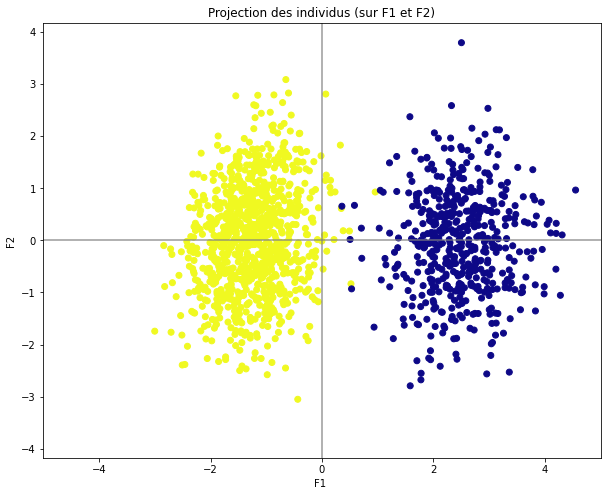

In [ ]:
display_factorial_planes(X_proj, (0,1), clusters=df.is_genuine, marker='o')

## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop("is_genuine", axis=1)
X = X.values
y = df.is_genuine
Y = y.values
Y = Y.reshape(len(Y),1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Algorithm de Régression Logistique

In [ ]:
# Standardisation des DATA
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Création & entraînement du modèle de régréssion logistique
log = LogisticRegression()
log.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [ ]:
# Évaluation du modèle
y_pred_log = log.predict(X_test)

In [ ]:
y_pred_log

array([ True, False,  True,  True, False,  True,  True, False,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
       False,  True,  True, False,  True, False,  True,  True, False,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True, False,

In [ ]:
log.score(X_test,y_test)

0.99

> La fiabilité de ce modèle est de **99,7 %**

In [ ]:
tst = pd.DataFrame(y_test)
prd = pd.DataFrame(y_pred_log)
c = tst.merge(prd, left_index=True, right_index=True)
c["correct"]= c["0_x"] == c["0_y"]
c

,0_x,0_y,correct
0,True,True,True
1,True,False,False
2,True,True,True
3,True,True,True
4,False,False,True
...,...,...,...
295,True,True,True
296,True,True,True
297,False,False,True
298,True,True,True


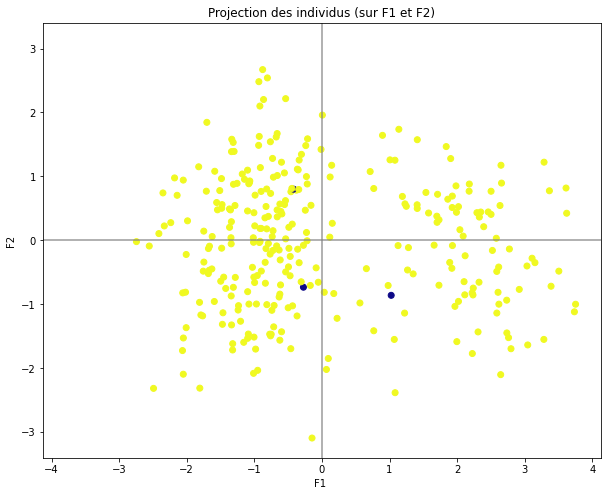

In [ ]:
pca = decomposition.PCA(2)
pca.fit_transform(X_train)
X_proj = pca.transform(X_test)

display_factorial_planes(X_proj, (0,1), clusters=(c.correct), marker='o')

In [ ]:
# Matrice de confusion
matrix = confusion_matrix(y_test, y_pred_log)
matrix

array([[ 93,   2],
       [  1, 204]])

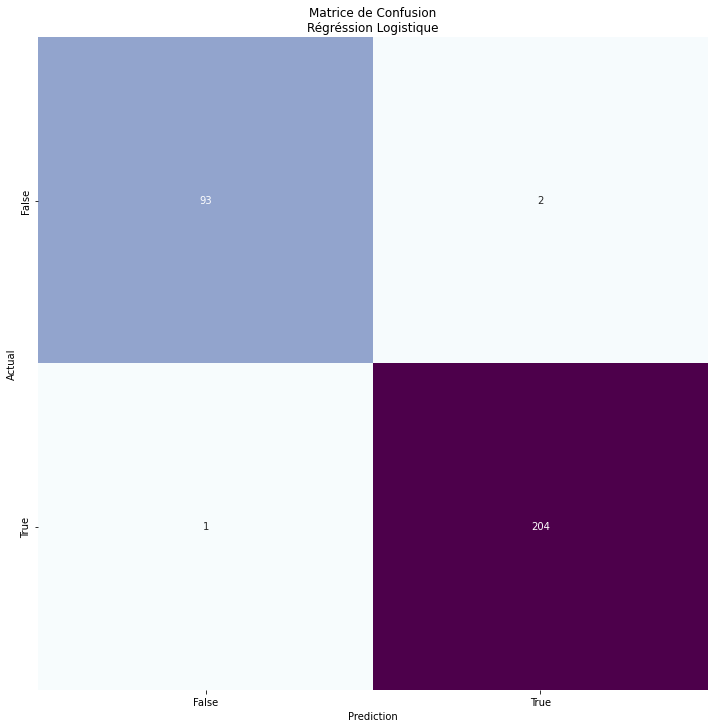

In [ ]:
# figure de la matrice de confusion
lbl = ["False","True"]
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True, fmt="d", cmap="BuPu",
            xticklabels= lbl, yticklabels= lbl, cbar=False)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Matrice de Confusion\nRégréssion Logistique")
plt.show()

## KMeans

In [ ]:
km = KMeans(n_clusters=2, init="k-means++")
km.fit_predict(X_train,y_train)

array([1, 0, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
y_pred_km = km.predict(X_test)
y_pred_km

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1], d

In [ ]:
tst = pd.DataFrame(y_test)
prd = pd.DataFrame(y_pred_km)
c = tst.merge(prd, left_index=True, right_index=True)
c["correct"]= c["0_x"] == c["0_y"]
c

,0_x,0_y,correct
0,True,0,False
1,True,1,True
2,True,0,False
3,True,0,False
4,False,1,False
...,...,...,...
295,True,0,False
296,True,0,False
297,False,1,False
298,True,0,False


In [ ]:
import collections
nbTrue = collections.Counter(c.correct)[True]
nbFalse = collections.Counter(c.correct)[False]
score = nbTrue/len(c)
score

0.016666666666666666

In [ ]:
def permut(y) :
  for i in range(len(y)) :
   if y[i]==0 :
       y[i] = 1
   else :
        y[i] = 0
  return(y)

In [ ]:
import collections
nbTrue = collections.Counter(c.correct)[True]
nbFalse = collections.Counter(c.correct)[False]
if nbFalse > nbTrue:
  permut(y_pred_km)
  

In [ ]:
tst = pd.DataFrame(y_test)
prd = pd.DataFrame(y_pred_km)
c = tst.merge(prd, left_index=True, right_index=True)
c["correct"]= c["0_x"] == c["0_y"]
c

,0_x,0_y,correct
0,True,1,True
1,True,0,False
2,True,1,True
3,True,1,True
4,False,0,True
...,...,...,...
295,True,1,True
296,True,1,True
297,False,0,True
298,True,1,True


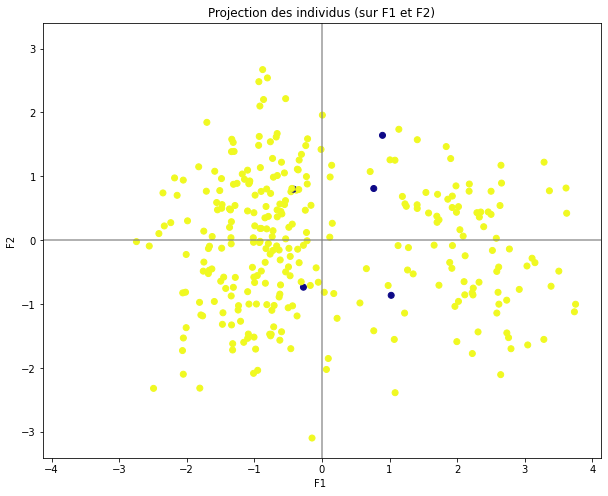

In [ ]:
display_factorial_planes(X_proj, (0,1), clusters=(c.correct), marker='o')

In [ ]:
# Matrice de confusion
matrix = confusion_matrix(y_test, y_pred_km)
matrix

array([[ 93,   2],
       [  3, 202]])

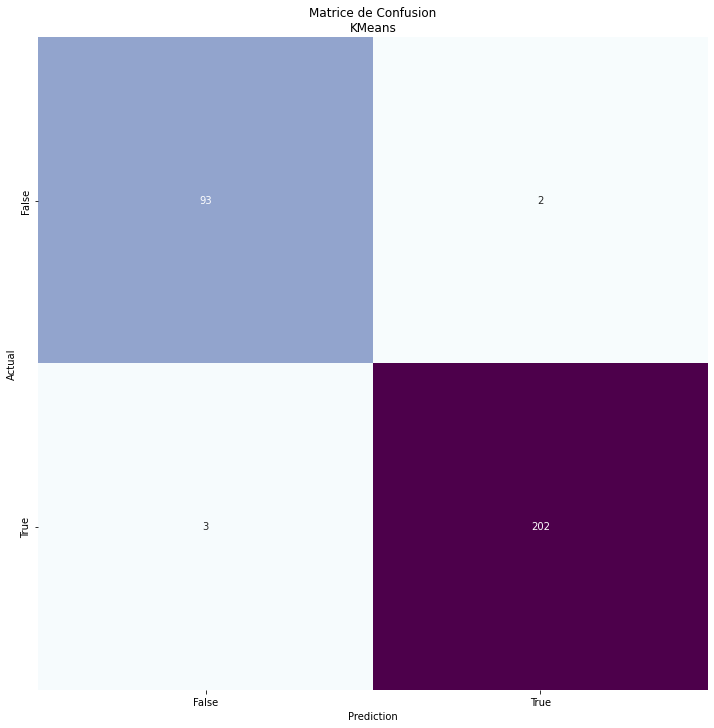

In [ ]:
# Plot de la matrice de confusion

lbl = ["False","True"]
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True, fmt="d", cmap="BuPu",
            xticklabels= lbl, yticklabels= lbl, cbar=False)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Matrice de Confusion\nKMeans")
plt.show()